In [1]:
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import numpy as np
import re
import os


In [2]:
%load_ext autoreload
%autoreload 2
    
from helpers.utils import _qq_stats_text
from helpers.utils import scree
from helpers.utils import learn_kde
from helpers.utils import score_with_kdes
from helpers.utils import reshape_to_cmat
import helpers.utils

In [3]:
OKABE = ['#E69F00','#56B4E9','#009E73','#F0E442',
         '#0072B2','#D55E00','#CC79A7','#000000']

In [4]:
trainfile = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_training_data.csv"
testfile = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_test_data.csv"

In [5]:
training_data = pd.read_csv(trainfile)
test_data = pd.read_csv(testfile)

In [6]:
lab2str = (training_data[['label','str_label']]
           .dropna().drop_duplicates('label').set_index('label')['str_label'].to_dict())

### Evaluate data

First z-normalize.
- evaluate the non-parametric nature
- scree plot
- classification error

In [7]:
df = training_data.copy()
feature_cols = df.columns[:16].tolist()

# Z-normalize all 16 features together
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(df[feature_cols].astype(float))

In [8]:
labels = df['label'].unique().tolist()
labels = sorted(labels, key=lambda x: str(x)) 

#### Evaluate the non-parametric nature

- Shapiro-Wilk (SW): normal null. W closer to $1$ indicates more normal, small p-value indicates rejection of the null. *observing extremely low probability of observing our data (or more extreme) if our data really came from a normally distributed population*
- Kolmogorov-Smirnov (KS): normal CDF. Descriptive check (we z-scored with empirical mean). Smaller D means closer to normal. Most sensitive near median (less in the tails). *observing extremely low probability of observing our data (or more extreme) if our data really came from a normally distributed population*
- Anderson-Darling (AD): normal null. Larger A means less normal. Compares $A^2$ to critical values, if $A^2 > \text{crit}(5\%)$ then we reject at $5\%$ significance. *$5\% > 0.786$ indicates the $5\%$ significance critical value is 0.786 and we reject normality at all features and classes.*

In [9]:
out_dir = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots/baseMemoir_nonparametric/"

plt.rcParams.update({"font.size": 9})

for lab in labels:
    m = (df['label'] == lab).to_numpy()
    Z = X[m]  # X is your z-scored (StandardScaler) features
    if Z.size == 0:
        continue

    fig, axes = plt.subplots(4, 4, figsize=(12, 10), dpi=150)
    for j, ax in enumerate(axes.ravel()):
        stats.probplot(Z[:, j], dist="norm", plot=ax)
        ax.set_title(feature_cols[j], fontsize=9)
        ax.set_xlabel(""); ax.set_ylabel("")
        ax.text(0.02, 0.98, _qq_stats_text(Z[:, j]),
                transform=ax.transAxes, fontsize=9, family='monospace',
                va='top', ha='left')

    fig.suptitle(f"QQ plots (z-norm) — label={lab} (n={Z.shape[0]})", fontsize=11)
    plt.tight_layout()

    safe_lab = re.sub(r'[^A-Za-z0-9._-]+', '_', str(lab))
    pdf = os.path.join(out_dir, f"qq_label_{safe_lab}.pdf")
    fig.savefig(pdf, bbox_inches='tight')
    plt.close(fig)

#### Evaluate the feature dimensions
1. Scree plot
2. Report statsmodels IMSE to compare rotated vs. z-normalized data in $\mathbb{R}^{16}$.
3. Report classification error across density dimensions $\mathbb{R}^{2 - 16}$.

In [10]:
print("Training data proportions")
pd.DataFrame(df['label'].value_counts(normalize=True))

Training data proportions


,proportion
label,
0,0.381121
3,0.221400
1,0.215357
2,0.182121


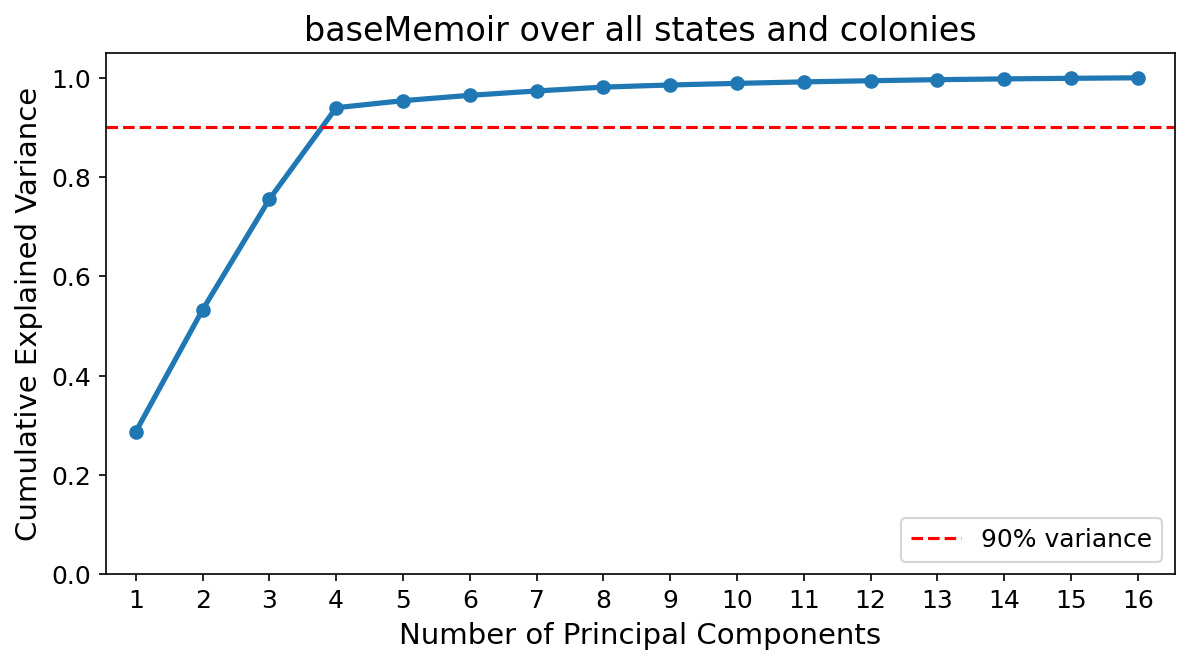

In [11]:
vr, cv = scree(X, out="/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots/baseMemoir_scree.pdf")

In [12]:
# construct Z = XV (rotation of X to concentrate variance with new basis)
# report statsmodels IMSE

pca = PCA(n_components=16)
Z = pca.fit_transform(X)

In [13]:
for label in labels:
    label_mask = df['label'] == label
    kde_X = learn_kde(X[label_mask])
    print(label, lab2str[label], "kde(X)", kde_X.imse(kde_X.bw))
    kde_Z = learn_kde(Z[label_mask])
    print(label, lab2str[label], "kde(Z)", kde_Z.imse(kde_Z.bw))

0 AA kde(X) -0.0003736846652369874
0 AA kde(Z) -4.243887788237652
1 GG kde(X) -7.647786779613418e-05
1 GG kde(Z) -2.6702799078294404
2 GA kde(X) -3.701401163526256e-05
2 GA kde(Z) -0.8124982338736145
3 AG kde(X) -0.00022648455780670618
3 AG kde(Z) -5.715091153391436


In [14]:
# Report classification error across dimensions

pca = PCA(n_components=16, random_state=0)
Z = pca.fit_transform(X) 

y = df['str_label'].astype(str).to_numpy()
classes = ['AA','GG','AG','GA']

In [15]:
k_range=range(1,17)
seeds=(0,1,2)
n_splits=5
bw = "normal_reference"

res = {'k': [], 'overall': [], 'per_class': {c: [] for c in classes}}
for k in k_range:
    tot_correct = 0; tot_n = 0
    corr_c = {c:0 for c in classes}; n_c = {c:0 for c in classes}
    for seed in seeds:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        for tr, te in skf.split(Z, y):
            Ztr, Zte = Z[tr, :k], Z[te, :k]
            ytr, yte = y[tr], y[te]
            
            kdes = {c: KDEMultivariate(Ztr[ytr==c], var_type='c'*k, bw=bw) for c in classes}
            
            logpdf = np.column_stack([np.log(np.clip(kdes[c].pdf(Zte), 1e-300, None)) for c in classes])
            pred  = np.array([classes[i] for i in logpdf.argmax(axis=1)])
            tot_correct += (pred == yte).sum(); tot_n += yte.size
            for c in classes:
                m = (yte == c)
                n_c[c] += m.sum()
                if m.any(): corr_c[c] += (pred[m] == c).sum()
    res['k'].append(k)
    res['overall'].append(tot_correct / tot_n)
    for c in classes:
        res['per_class'][c].append(corr_c[c] / max(1, n_c[c]))

In [16]:
PALETTE = {
    'AA': OKABE[1],   # sky blue
    'GG': OKABE[0],   # orange
    'AG': OKABE[5],   # vermillion
    'GA': OKABE[2],   # bluish green
    'Overall': OKABE[7],  # black
}

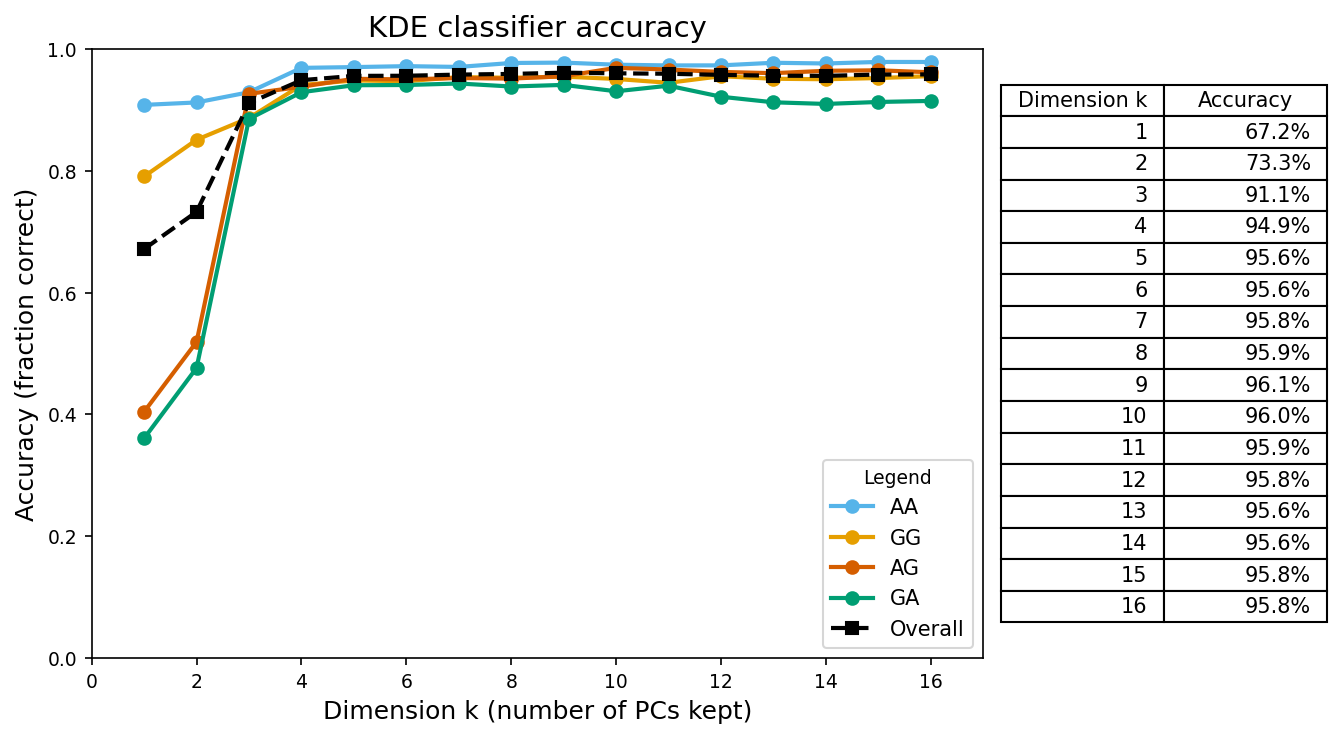

In [17]:
from matplotlib.gridspec import GridSpec

ks  = np.array(res['k'])
ovr = np.array(res['overall'])
fig = plt.figure(figsize=(9,5), dpi=150)
gs  = GridSpec(1, 2, width_ratios=[3.0, 1.0], figure=fig)

ax = fig.add_subplot(gs[0,0])
for c in classes:
    ax.plot(ks, res['per_class'][c], marker='o', linewidth=2,
            color=PALETTE[c], label=c)
ax.plot(ks, ovr, marker='s', linestyle='--', color=PALETTE['Overall'],
        linewidth=2, label='Overall')

ax.set_title('KDE classifier accuracy', fontsize=14)
ax.set_xlabel('Dimension k (number of PCs kept)', fontsize=12)
ax.set_ylabel('Accuracy (fraction correct)', fontsize=12)
ax.set_ylim(0, 1.0); ax.set_xlim(0, 17)
# ax.grid(True, alpha=0.3)
ax.legend(title='Legend', loc='lower right', fontsize=10)

# right-side table of overall accuracy
axT = fig.add_subplot(gs[0,1]); axT.axis('off')
tbl = [[int(k), f"{100*a:.1f}%"] for k, a in zip(ks, ovr)]
table = axT.table(cellText=tbl, colLabels=['Dimension k','Accuracy'], loc='center')
table.auto_set_font_size(False); table.set_fontsize(10); table.scale(1.1, 1.2)

fig.tight_layout()
fig.savefig('/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/plots/baseMemoir_kde_classifier_accuracy.pdf', bbox_inches='tight')
plt.show()

### Score the test data
1. Train KDEs on all the training data, to be used to score Colony 2 and 5.
2. Split the test data into Colony 2 and Colony 5. Subset to those cells observed in the published tree.

#### Train KDEs

In [7]:
df_train = training_data.copy()
feature_cols = df_train.columns[:16].tolist()

# Z-normalize all 16 features together
scaler = StandardScaler(with_mean=True, with_std=True)
# PCA to 5 dimensions
pca = PCA(n_components=5, random_state=0)

# standardize and PCA the training data
X_train_scaled = scaler.fit_transform(df_train[feature_cols].astype(float))
X_train_pca = pca.fit_transform(X_train_scaled)

# also standardize and PCA the test data
df_test = test_data.copy()
feature_cols = [f'feature_{x}' for x in range(16)]

X_test_scaled = scaler.transform(df_test[feature_cols])  
X_test_pca = pca.transform(X_test_scaled)

In [8]:
y_train = df_train['label']
classes = sorted(np.unique(y_train))

kde_by_class = {}
var_type = 'c' * X_train_pca.shape[1]
bw_method = 'normal_reference'

kde_by_class = {c: learn_kde(X_train_pca[y_train == c], var_type='c'*5) for c in classes}

Note that the categorical class labels here (for each trained KDE) are consistent with the class labels in the training data, so the test sample classes will match.

In [9]:
kde_by_class

{np.int64(0): KDE instance
 Number of variables: k_vars = 5
 Number of samples:   nobs = 3658
 Variable types:      ccccc
 BW selection method: normal_reference,
 np.int64(1): KDE instance
 Number of variables: k_vars = 5
 Number of samples:   nobs = 2067
 Variable types:      ccccc
 BW selection method: normal_reference,
 np.int64(2): KDE instance
 Number of variables: k_vars = 5
 Number of samples:   nobs = 1748
 Variable types:      ccccc
 BW selection method: normal_reference,
 np.int64(3): KDE instance
 Number of variables: k_vars = 5
 Number of samples:   nobs = 2125
 Variable types:      ccccc
 BW selection method: normal_reference}

#### Pre-processing metadata

In [10]:
df_test = test_data.copy()

df_test['true_cassette_idx'] = df_test['cassette_idx']
sites_per_cassette = max(df_test['site_idx'])
df_test['target_site'] = (df_test['true_cassette_idx']-1) * sites_per_cassette + df_test['site_idx']-1
df_test['cassette_idx'] = 0

In [11]:
df_test

,cassette_idx,cell_name,colony,site_idx,bMp_AA,bMp_GG,bMp_GA,bMp_AG,bM_str_geno,bM_pmax,...,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,bM_geno,true_cassette_idx,target_site
0,0,1,1,1,0.001505,0.909489,0.087431,0.001574,GG,0.909489,...,5.998937,7.137278,4.343805,13.414877,10.442790,12.074642,6.916006,1,1,0
1,0,1,1,2,0.000201,0.350080,0.004905,0.644814,AG,0.644814,...,4.859812,5.459586,8.599879,13.139092,7.979672,9.143101,14.925368,3,1,1
2,0,1,1,3,0.940735,0.010919,0.046383,0.001963,AA,0.940735,...,7.779467,6.280396,4.644391,6.160170,13.279019,9.722703,7.240190,0,1,2
3,0,1,1,4,0.942045,0.023386,0.032878,0.001690,AA,0.942045,...,7.662468,6.453625,4.158883,5.673921,12.907225,10.776704,8.745427,0,1,3
4,0,1,1,5,0.004091,0.567286,0.311299,0.117325,GG,0.567286,...,5.537334,7.593374,7.568379,12.488600,9.625884,13.112572,12.945165,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90463,0,9,9,2,0.979866,0.012860,0.000210,0.007064,AA,0.979866,...,7.425954,4.941642,5.752573,6.309114,12.192291,8.228100,9.489516,0,9,49
90464,0,9,9,3,0.987961,0.010284,0.000639,0.001116,AA,0.987961,...,7.643483,5.241747,4.927254,6.896179,13.099163,8.942562,8.210779,0,9,50
90465,0,9,9,4,0.966041,0.001472,0.032212,0.000274,AA,0.966041,...,7.553287,6.059123,3.295837,4.280324,12.767015,9.989126,6.528503,0,9,51
90466,0,9,9,5,0.022644,0.664211,0.000001,0.313143,GG,0.664211,...,5.730100,3.178054,7.552237,12.141150,9.338231,5.023106,12.887858,1,9,52


#### Handle Colonies 2 and 5 (no multi-image correspondence)

In [12]:
# Filter out cells which are not in the published tree

col2_cellnames_fname = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.colony2.published.cellnames.txt"
col5_cellnames_fname = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.colony5.published.cellnames.txt"

col2_cellnames = set([int(x) for x in (
    pd.read_csv(col2_cellnames_fname, header=None, dtype=str)
      .squeeze("columns")
      .to_numpy()).tolist()])

col5_cellnames = set([int(x) for x in (
    pd.read_csv(col5_cellnames_fname, header=None, dtype=str)
      .squeeze("columns")
      .to_numpy()).tolist()])

In [13]:
colony2_mask = (df_test["colony"] == 2) & (df_test["cell_name"].astype(int).isin({int(x) for x in col2_cellnames}))
colony5_mask = (df_test["colony"] == 5) & (df_test["cell_name"].astype(int).isin({int(x) for x in col5_cellnames}))

metadata_cols = ['cell_name', 'site_idx', 'cassette_idx', 'target_site']

meta_col2 = df_test[colony2_mask][metadata_cols].reset_index(drop=True)
meta_col5 = df_test[colony5_mask][metadata_cols].reset_index(drop=True)

In [14]:
col2_X_test = X_test_pca[colony2_mask]
col5_X_test = X_test_pca[colony5_mask]
print("Colony 2", col2_X_test.shape)
print("Colony 5", col5_X_test.shape)

Colony 2 (8322, 5)
Colony 5 (8088, 5)


In [15]:
col2_preds, col2_scores = score_with_kdes(col2_X_test, kde_by_class)

In [16]:
col5_preds, col5_scores = score_with_kdes(col5_X_test, kde_by_class)

In [17]:
scores_col2 = col2_scores.reset_index(drop=True)
scores_col5 = col5_scores.reset_index(drop=True)

Check proportions of baseMemoir genotypes and the KDE argmax genotypes, over Colony 2 and Colony 5.

In [18]:
pd.DataFrame(df_test[colony2_mask]['bM_geno'].value_counts(normalize=True)), pd.DataFrame(col2_preds['pred_label'].value_counts(normalize=True))

(         proportion
 bM_geno            
 0          0.682288
 1          0.176760
 3          0.089041
 2          0.051911,
             proportion
 pred_label            
 0             0.734439
 1             0.126652
 3             0.076063
 2             0.062845)

In [19]:
df_test[colony5_mask]['bM_geno'].value_counts(normalize=True), col5_preds['pred_label'].value_counts(normalize=True)

(bM_geno
 0    0.616840
 1    0.203635
 3    0.098541
 2    0.080984
 Name: proportion, dtype: float64,
 pred_label
 0    0.650841
 1    0.169881
 2    0.095326
 3    0.083952
 Name: proportion, dtype: float64)

In [20]:
col2_scores.isna().sum().sum(), col5_scores.isna().sum().sum()

(np.int64(0), np.int64(0))

In [21]:
# gather metadata columns and merge into score tables
col2_table = pd.concat([meta_col2, scores_col2], axis=1)
col5_table = pd.concat([meta_col5, scores_col5], axis=1)

In [22]:
cols = ['cell_name', 'cassette_idx', 'target_site'] + [f'state{x}_prob' for x in range(4)]
col2_table = col2_table[cols]

cols = ['cell_name', 'cassette_idx', 'target_site'] + [f'state{x}_prob' for x in range(4)]
col5_table = col5_table[cols]

print("Target site range:", min(col2_table['target_site']), max(col2_table['target_site']))
print("Target site range:", min(col5_table['target_site']), max(col5_table['target_site']))

col2_table = col2_table.sort_values(by=['cell_name', 'target_site'], ascending=[True, True])
col5_table = col5_table.sort_values(by=['cell_name', 'target_site'], ascending=[True, True])

col2_table.to_csv('/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_colony2_kde_scores.csv', index=False)
col5_table.to_csv('/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_colony5_kde_scores.csv', index=False)

Target site range: 0 395
Target site range: 0 395


Write the argmax to character matrix form, so we can generate starting trees.

In [23]:
# gather metadata columns
states_col2 = col2_preds['pred_label'].reset_index(drop=True)
states_col5 = col5_preds['pred_label'].reset_index(drop=True)

cols = ['cell_name', 'target_site', 'pred_label'] 
col2_state_table = pd.concat([meta_col2, states_col2], axis=1)[cols]
col5_state_table = pd.concat([meta_col5, states_col5], axis=1)[cols]


In [24]:
col2_cmat = reshape_to_cmat(col2_state_table).T
col2_cmat.to_csv('/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_colony2_kde_character_matrix.csv')
col5_cmat = reshape_to_cmat(col5_state_table).T
col5_cmat.to_csv('/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_colony5_kde_character_matrix.csv')

Write the df_test baseMemoir probabilities and genotypes to a file for Colony 2 and Colony 5.

In [25]:
cols = ['cell_name', 'colony', 'site_idx', 'cassette_idx', 'target_site', 'bMp_AA', 'bMp_GG',
       'bMp_GA', 'bMp_AG', 'bM_str_geno', 'bM_pmax', 'bM_geno']

In [26]:
bM_col2 = df_test[colony2_mask][cols]
print("Shape of bM_col2 (already filtered to keep published tree cells):", bM_col2.shape)

Shape of bM_col2 (already filtered to keep published tree cells): (8322, 12)


In [27]:
bM_col5 = df_test[colony5_mask][cols]
print("Shape of bM_col5 (already filtered to keep published tree cells):", bM_col5.shape)

Shape of bM_col5 (already filtered to keep published tree cells): (8088, 12)


In [28]:
bM_col2.to_csv('/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_colony2_baseMemoir_genotypes.csv', index=False)
bM_col5.to_csv('/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/baseMemoir_colony5_baseMemoir_genotypes.csv', index=False)

#### Handle Colonies 78 and 910 (imaged twice)

1. Group colonies and resolve the duplicate-imaged cells. Construct a clean matrix.
2. Output `kde_scores`, `kde_character_matrix`, `baseMemoir_genotypes`.

In [29]:
# Filter out cells which are not in the published tree

col78_cellnames_fname = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.colony78.published.cellnames.txt"
col910_cellnames_fname = "/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/inputs/trees/baseMemoir.colony910.published.cellnames.txt"

col78_cellnames = set([int(x) for x in (
    pd.read_csv(col78_cellnames_fname, header=None, dtype=str)
      .squeeze("columns")
      .to_numpy()).tolist()])

col910_cellnames = set([int(x) for x in (
    pd.read_csv(col910_cellnames_fname, header=None, dtype=str)
      .squeeze("columns")
      .to_numpy()).tolist()])

In [32]:
# Hardcoded and chosen in matlab code (All_Colonies_SVM.m)

pos10_keep_cells = [1,2,3,4,5,6,7,18]
# pos9_drop_cells  = [1,2] # corresponding cells are in pos10_keep_cells

pos8_keep_cells = [0, 5, 7, 10, 11, 13, 16, 17, 20,
                                    23, 24, 26, 30, 32, 35, 38, 43,
                                    46, 50, 52]
# pos7_drop_cells = [53, 63] # corresponding cells are in pos8_keep_cells

multi_im_corr = pd.read_csv("/Users/gc3045/git/laml2-experiments/real_data/baseMemoir/BaseMEM_Magic/Magic/Figures3_5_and_SupFigures2_4-6/230226_multi-im_correspondance_forMatlab.csv", header=None)
multi_im_corr.columns = ['Cell1', 'Cell2', 'Cell1_pos', 'Cell2_pos']

corr78  = multi_im_corr[(multi_im_corr["Cell1_pos"] == 7)  & (multi_im_corr["Cell2_pos"] == 8)]
corr910 = multi_im_corr[(multi_im_corr["Cell1_pos"] == 9)  & (multi_im_corr["Cell2_pos"] == 10)]

map8_to_7  = dict(zip(corr78["Cell2"],  corr78["Cell1"])) 
map10_to_9 = dict(zip(corr910["Cell2"], corr910["Cell1"]))

After subtracting off these cells for which we don't have observed data, we have 38 cells in Colony 7/8 and 36 cells in Colony 9/10. This is before resolving cells which were imaged twice (deduplication of observations). We attempt to resolve duplications below, but a) we still cannot resolve these cell names, and b) we are still left with duplications. 

As this is about the same number of cells in Colonies 2 and 5, which don't have duplications to resolve, we proceed with Colonies 2 and 5. 

1. Mask the colonies according to the hardcoded values.
2. Collapse 7/8 duplicates by preferring the pos7 row; if only one side exists, keep that side.

In [34]:
mask8  = df_test["colony"] == 8
mask7  = df_test["colony"] == 7
mask9  = df_test["colony"] == 9
mask10 = df_test["colony"] == 10

mask_78 = (mask8) | (mask7)
mask_910 = (mask9) | (mask10)
# ((mask8 & df_test["cell_name"].isin(pos8_keep_cells)) | (mask7))
# mask_910 = ((mask10 & df_test["cell_name"].isin(pos10_keep_cells_py)) | (mask9))

metadata_cols = ['cell_name', 'site_idx', 'colony', 'cassette_idx', 'target_site']

meta_col78  = df_test.loc[mask_78,  metadata_cols].reset_index(drop=True)
meta_col910 = df_test.loc[mask_910, metadata_cols].reset_index(drop=True)

col78_X_test  = X_test_pca[mask_78]
col910_X_test = X_test_pca[mask_910]

print("Colony 78", col78_X_test.shape)
print("Colony 910", col910_X_test.shape)

Colony 78 (27378, 5)
Colony 910 (21738, 5)


In [35]:
print([x for x in col78_cellnames if x not in meta_col78['cell_name'].unique()])
print([x for x in col910_cellnames if x not in meta_col910['cell_name'].unique()])

[75, 77, 78, 81, 82, 83, 84, 85, 86, 87, 89, 90]
[52, 53, 55, 56, 57]


In [36]:
print(len(col78_cellnames)-len([x for x in col78_cellnames if x not in meta_col78['cell_name'].unique()]))
print(len(col910_cellnames)-len([x for x in col910_cellnames if x not in meta_col910['cell_name'].unique()]))

38
36


In [37]:
meta_col78["stitched_colony"] = meta_col78["colony"]
meta_col78["stitched_cell"] = meta_col78["cell_name"]

# for cells in pos8_keep_cells_py, let's keep these and drop pos7 cells 

# for cells in pos7_drop_cells_py, keep the pos8 cells

map8_keys = set(map8_to_7.keys())
drop_mapped_8 = mask8 & df_test["cell_name"].isin(map8_keys)
keep_mask_78 = mask_78 & ~drop_mapped_8

metadata_cols = ['cell_name', 'site_idx', 'colony', 'cassette_idx', 'target_site']
meta_col78 = df_test.loc[keep_mask_78, metadata_cols].copy()

meta_col78["stitched_colony"] = 78         
# duplicate cells: use pos7 cell_name and observations; unmatched pos8 also stay
meta_col78["stitched_cell"]   = meta_col78["cell_name"]  

col78_X_test = X_test_pca[keep_mask_78]

In [38]:
print("Still duplicated?", meta_col78.loc[meta_col78['stitched_colony'] == 78, ['stitched_cell', 'stitched_colony', 'target_site']].duplicated().any())

Still duplicated? True


In [39]:
meta_col78.loc[meta_col78['stitched_colony'] == 78, ['stitched_cell', 'stitched_colony', 'target_site']].duplicated().sum()

np.int64(2580)